In [20]:
import pandas as pd

df = pd.read_csv('NASA.csv')
print(df.head())
print("Columns:", list(df.columns))

        id                 name  est_diameter_min  est_diameter_max  \
0  2162635  162635 (2000 SS164)          1.198271          2.679415   
1  2277475    277475 (2005 WK4)          0.265800          0.594347   
2  2512244   512244 (2015 YE18)          0.722030          1.614507   
3  3596030          (2012 BV13)          0.096506          0.215794   
4  3667127          (2014 GE35)          0.255009          0.570217   

   relative_velocity  miss_distance orbiting_body  sentry_object  \
0       13569.249224   5.483974e+07         Earth          False   
1       73588.726663   6.143813e+07         Earth          False   
2      114258.692129   4.979872e+07         Earth          False   
3       24764.303138   2.543497e+07         Earth          False   
4       42737.733765   4.627557e+07         Earth          False   

   absolute_magnitude  hazardous  
0               16.73      False  
1               20.00       True  
2               17.83      False  
3               22.20   

In [21]:
print(list(df.columns))


['id', 'name', 'est_diameter_min', 'est_diameter_max', 'relative_velocity', 'miss_distance', 'orbiting_body', 'sentry_object', 'absolute_magnitude', 'hazardous']


In [22]:
import numpy as np

# Choose features you want to use
features = [
    'est_diameter_min',
    'est_diameter_max',
    'relative_velocity',
    'miss_distance',
    'absolute_magnitude'
]

target_col = 'hazardous'  # This is your hazard flag

# Clean data
df_clean = df.dropna(subset=features + [target_col])

# Convert target to binary: 1 = hazardous, 0 = not
df_clean['label'] = df_clean[target_col].astype(str).str.upper().map({'TRUE': 1, 'FALSE': 0, 'Y': 1, 'N': 0, 1: 1, 0: 0})

X = df_clean[features].values.astype(np.float32)
y = df_clean['label'].values.astype(np.float32).reshape(-1, 1)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Hazardous ratio:", y.mean())

X shape: (90836, 5)
y shape: (90836, 1)
Hazardous ratio: 0.09731825


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split into train/test sets (stratify keeps class ratio similar in both)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize using only the training data stats
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
from nn import MLP
from engine import Value

In [25]:
def sigmoid(x):
    return Value(1.0) / (Value(1.0) + (-x).exp())

def binary_cross_entropy(pred, target):
    eps = 1e-7
    pred = pred * (1 - eps) + eps
    one = Value(1.0)
    t = Value(float(target))
    return -(t * pred.log() + (one - t) * (one - pred).log())

In [53]:
n_inputs = X_train_scaled.shape[1]   # should be 5
hidden_sizes = [16, 8]               # try 16 and 8 units; tune as you wish
model = MLP(nin=n_inputs, nouts=hidden_sizes + [1])  # Last layer is 1 for binary

In [27]:
def train_epoch(model, X, y, lr=0.01):
    total_loss = 0.0
    for xi, yi in zip(X, y):
        # Convert each input to micrograd Value
        input_vals = [Value(float(x)) for x in xi]
        out = model(input_vals)        # Output is a list with 1 element (Value)
        pred = sigmoid(out)               # Convert output to probability
        loss = binary_cross_entropy(pred, float(yi[0]))   # Target is 0.0 or 1.0

        zero_grad(model)              # Reset gradients
        loss.backward()
        clip = 5.0
        for p in model.parameters():
            if p.grad > clip:
                p.grad = clip
            elif p.grad < -clip:
                p.grad = -clip
            p.data -= lr * p.grad         # Simple SGD

        total_loss += loss.data           # loss.data is Python float

    return total_loss / len(X)
def zero_grad(model):
    for p in model.parameters():
        p.grad = 0.0
# Training loop
n_epochs = 20
for epoch in range(n_epochs):
    avg_loss = train_epoch(model, X_train_scaled, y_train, lr=0.001)
    print(f"Epoch {epoch+1:2d}: Avg Loss = {avg_loss:.6f}")

Epoch  1: Avg Loss = 0.414846
Epoch  2: Avg Loss = 0.403307
Epoch  3: Avg Loss = 0.402388
Epoch  4: Avg Loss = 0.401992
Epoch  5: Avg Loss = 0.401728
Epoch  6: Avg Loss = 0.401524
Epoch  7: Avg Loss = 0.401351
Epoch  8: Avg Loss = 0.401192
Epoch  9: Avg Loss = 0.401040
Epoch 10: Avg Loss = 0.400915
Epoch 11: Avg Loss = 0.400803
Epoch 12: Avg Loss = 0.400701
Epoch 13: Avg Loss = 0.400607
Epoch 14: Avg Loss = 0.400520
Epoch 15: Avg Loss = 0.400439
Epoch 16: Avg Loss = 0.400365
Epoch 17: Avg Loss = 0.400296
Epoch 18: Avg Loss = 0.400231
Epoch 19: Avg Loss = 0.400171
Epoch 20: Avg Loss = 0.400113


In [56]:
def predict(model, X, threshold=0.5):
    preds = []
    for xi in X:
        input_vals = [Value(float(x)) for x in xi]
        out = model(input_vals)
        prob = sigmoid(out).data
        preds.append(1 if prob > threshold else 0)
    return np.array(preds)

In [57]:
from sklearn.metrics import classification_report

y_pred = predict(model, X_test_scaled)
y_true = y_test.flatten()   # flatten shape (n, 1) to (n,)
print("New Model Results (Micrograd+MLP):")
print(classification_report(y_true, y_pred, digits=4))

New Model Results (Micrograd+MLP):
              precision    recall  f1-score   support

         0.0     0.8747    0.6327    0.7343     16400
         1.0     0.0447    0.1595    0.0699      1768

    accuracy                         0.5867     18168
   macro avg     0.4597    0.3961    0.4021     18168
weighted avg     0.7940    0.5867    0.6697     18168



In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HazardMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )
    def forward(self, x):
        return self.net(x)

In [42]:
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'

X_train_pt = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_pt = torch.tensor(y_train, dtype=torch.float32)
X_test_pt  = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_pt  = torch.tensor(y_test, dtype=torch.float32)

In [43]:
model = HazardMLP(input_dim=X_train_pt.shape[1])

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Class weighting for rare class
neg, pos = np.bincount(y_train.flatten().astype(int))
pos_weight = torch.tensor([neg / pos], dtype=torch.float32).to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
#criterion = nn.BCEWithLogitsLoss()  # For binary classification

n_epochs = 20
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    logits = model(X_train_pt).squeeze(1)  # Shape: (N,)
    loss = criterion(logits, y_train_pt.squeeze(1))
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1:2d}: Loss = {loss.item():.6f}")

Epoch  1: Loss = 1.251189
Epoch  2: Loss = 1.228649
Epoch  3: Loss = 1.208679
Epoch  4: Loss = 1.190788
Epoch  5: Loss = 1.173263
Epoch  6: Loss = 1.155311
Epoch  7: Loss = 1.136790
Epoch  8: Loss = 1.117831
Epoch  9: Loss = 1.098756
Epoch 10: Loss = 1.080147
Epoch 11: Loss = 1.062461
Epoch 12: Loss = 1.046133
Epoch 13: Loss = 1.031517
Epoch 14: Loss = 1.018709
Epoch 15: Loss = 1.007417
Epoch 16: Loss = 0.997035
Epoch 17: Loss = 0.986785
Epoch 18: Loss = 0.975943
Epoch 19: Loss = 0.964039
Epoch 20: Loss = 0.950892


In [44]:
from sklearn.metrics import classification_report

model.eval()
with torch.no_grad():
    logits = model(X_test_pt).squeeze(1)
    probs = torch.sigmoid(logits).cpu().numpy()
    y_true = y_test_pt.cpu().numpy().flatten().astype(int)

for thresh in [0.5, 0.3, 0.2]:
    y_pred = (probs > thresh).astype(int)
    print(f"\n=== Threshold: {thresh} ===")
    print(classification_report(y_true, y_pred, digits=4))


=== Threshold: 0.5 ===
              precision    recall  f1-score   support

           0     0.9936    0.7087    0.8273     16400
           1     0.2617    0.9576    0.4110      1768

    accuracy                         0.7329     18168
   macro avg     0.6276    0.8331    0.6192     18168
weighted avg     0.9224    0.7329    0.7868     18168


=== Threshold: 0.3 ===
              precision    recall  f1-score   support

           0     1.0000    0.2627    0.4161     16400
           1     0.1276    1.0000    0.2263      1768

    accuracy                         0.3344     18168
   macro avg     0.5638    0.6313    0.3212     18168
weighted avg     0.9151    0.3344    0.3976     18168


=== Threshold: 0.2 ===
              precision    recall  f1-score   support

           0     1.0000    0.0002    0.0004     16400
           1     0.0973    1.0000    0.1774      1768

    accuracy                         0.0975     18168
   macro avg     0.5487    0.5001    0.0889     18168
we

In [46]:
import torch.optim as optim

class HazardMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )
    def forward(self, x):
        return self.net(x)

model = HazardMLP(X_train_pt.shape[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [47]:
# Class weighting for rare class
neg, pos = np.bincount(y_train.flatten().astype(int))
pos_weight = torch.tensor([neg / pos], dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [48]:
#  Training loop
n_epochs = 20
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    logits = model(X_train_pt).squeeze(1)
    loss = criterion(logits, y_train_pt.squeeze(1))
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1:2d}: Loss = {loss.item():.6f}")

#  Predict probabilities
model.eval()
with torch.no_grad():
    logits = model(X_test_pt).squeeze(1)
    probs = torch.sigmoid(logits).cpu().numpy()
    y_true = y_test_pt.cpu().numpy().flatten().astype(int)


Epoch  1: Loss = 1.346123
Epoch  2: Loss = 1.311296
Epoch  3: Loss = 1.281578
Epoch  4: Loss = 1.254907
Epoch  5: Loss = 1.230317
Epoch  6: Loss = 1.207191
Epoch  7: Loss = 1.185189
Epoch  8: Loss = 1.163604
Epoch  9: Loss = 1.141732
Epoch 10: Loss = 1.119278
Epoch 11: Loss = 1.096110
Epoch 12: Loss = 1.072016
Epoch 13: Loss = 1.046826
Epoch 14: Loss = 1.020402
Epoch 15: Loss = 0.992829
Epoch 16: Loss = 0.964379
Epoch 17: Loss = 0.935393
Epoch 18: Loss = 0.906276
Epoch 19: Loss = 0.877487
Epoch 20: Loss = 0.849487



Best F1 threshold: 0.452, F1: 0.4606


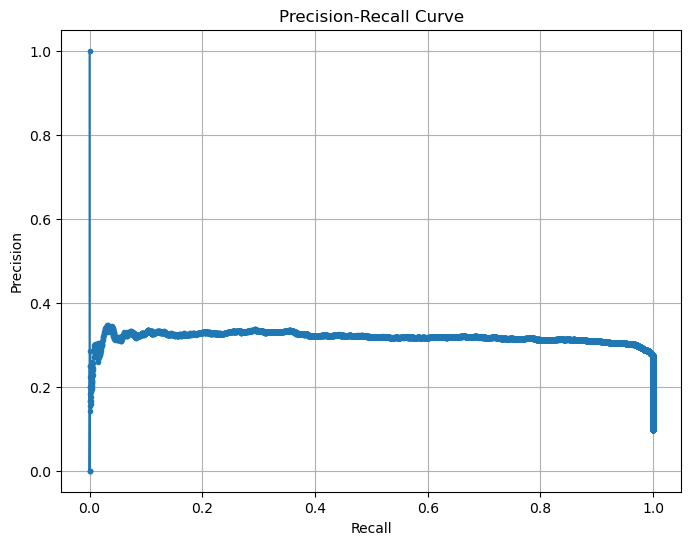


=== Classification report at best F1 threshold ===
              precision    recall  f1-score   support

           0     0.9917    0.7689    0.8662     16400
           1     0.3050    0.9406    0.4606      1768

    accuracy                         0.7856     18168
   macro avg     0.6484    0.8548    0.6634     18168
weighted avg     0.9249    0.7856    0.8267     18168



In [49]:
from sklearn.metrics import classification_report, precision_recall_curve, f1_score
import matplotlib.pyplot as plt

#  Precision-Recall curve and F1 optimization
precisions, recalls, thresholds = precision_recall_curve(y_true, probs)
f1s = []
for thresh in thresholds:
    y_pred = (probs > thresh).astype(int)
    f1s.append(f1_score(y_true, y_pred))

best_idx = np.argmax(f1s)
best_thresh = thresholds[best_idx]
print(f"\nBest F1 threshold: {best_thresh:.3f}, F1: {f1s[best_idx]:.4f}")

# Plot PR curve
plt.figure(figsize=(8,6))
plt.plot(recalls, precisions, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

# Show detailed report for best threshold
y_pred_best = (probs > best_thresh).astype(int)
print("\n=== Classification report at best F1 threshold ===")
print(classification_report(y_true, y_pred_best, digits=4))